# 직접 해보기

## 모듈화 코드

In [2]:
############################
# 모듈 import
############################
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import accuracy_score

from tqdm import tqdm

In [44]:
############################
# 사전 클래스 정의
############################
class GerEngVocab():
    def __init__(self, datas, max_len):
        
        data_iter = self.__iter_vocab(datas)
        
        sep_list = ['<unk>', '<pad>', '<sos>', '<eos>']
        
        self.vocab = build_vocab_from_iterator(
            data_iter,
            specials=sep_list
        )
        
        self.vocab.set_default_index(self.vocab['<unk>'])
        
        self.vocab_size = len(self.vocab)

        self.idx2word = self.vocab.get_itos()
        self.word2idx = self.vocab.get_stoi()
    
    def __len__(self):
        return self.vocab_size
    
    def __getitem__(self, idx):
        return self.idx2word[idx]
    
    # 단어 -> 인덱스
    def wrd2idx(self, word):
        return self.word2idx[word]
    
    # 인덱스 -> 단어
    def idx2wrd(self, idx):
        return self.idx2word[idx]
    
    # vocab 생성을 위한 iterator
    def __iter_vocab(datas):
        for data in tqdm(datas):
            yield data

In [ ]:
############################
# 데이터셋 클래스 정의
############################
class GerEngDataset(Dataset):
    ########################
    # 필수 함수 정의
    ########################
    def __init__(self, vocab, X, y=[], max_len=10, emb_type='ohe', train_mode=True):
        
        self.__train_mode = train_mode if y == [] else False
        self.__emb_type = emb_type
        self.__max_len = max_len
        self.__vocab = GerEngVocab(X+y, max_len)
        self.__oh_vector = torch.eye(self.__vocab)
        self.__X = self.__tokenizer(X)
        
        if y != []:
            _y = y
            self.__y = self.__tokenizer(y)
            self.__dec_input = self.__add_sep_token(self.__y)
            self.__target = self.__add_sep_token(self.__y, sep_token='<eos>')
            self.__fake_dec_input = self.__add_sep_token(self.__get_initial_dec_input())
        else:
            self.__y = None
            self.__fake_dec_input = self.__add_sep_token(self.__get_initial_dec_input())
            pass
        
    def __len__(self):
        return len(self.__X)
    
    def __getitem__(self, idx):
        if self.__emb_type == 'ohe':
            return self.__ohe_getitem(idx)
        elif self.__emb_type == 'emb':
            return self.__emb_getitem(idx)
        
    ########################
    # 기타 함수 정의
    ########################
    def __ohe_getitem(self, idx):
        ohe_X = self.__oh_encoding(self.__X[idx])
        if self.__train_mode and self.__y is not None:
            ohe_dec_input = self.__oh_encoding(self.__dec_input[idx])
            ohe_target = self.__oh_encoding(self.__target[idx])
            return torch.tensor(ohe_X), torch.tensor(ohe_dec_input), torch.tensor(ohe_target)
        else:
            ohe_dec_input = self.__oh_encoding(self.__fake_dec_input[idx])
            return torch.tensor(ohe_X), torch.tensor(ohe_dec_input), torch.tensor(ohe_dec_input)
    
    def __emb_getitem(self, idx):
        if self.__train_mode and self.__y is not None:
            return self.__X[idx], self.__dec_input[idx], self.__target[idx]
        else:
            return self.__X[idx], self.__fake_dec_input[idx], self.__fake_dec_input[idx].copy()
    
    def __tokenizer(self, datas):
        padding_datas = self.__padding(datas)
        for data in padding_datas:
            data = [self.__vocab.wrd2idx(wrd) for wrd in data]
        return np.array(padding_datas)
    
    def __padding(self, datas):
        for data in datas:
            data = data + ['<pad>' for _ in range(self.__max_len-len(data))]
        return datas
    
    def __oh_encoding(self, datas):
        return self.__oh_vector[self.__vocab.wrd2idx(datas)]
    
    def __add_sep_token(self, token_datas, sep_token='<sos>'):
        added_array = None
        _array = np.array([self.__vocab.wrd2idx(sep_token) for _ in range(len(self.__X))])
        if sep_token == '<sos>':
            added_array = np.concatenate((_array.reshape(-1, 1), token_datas), axis=1)
        elif sep_token == '<eos>':
            added_array = np.concatenate((token_datas, _array.reshape(-1, 1)), axis=1)
        return added_array
    
    def __get_initial_dec_input(self):
        fake_dec_input = []
        for _ in range(len(self.__X)):
            fake_dec_input.append([self.__vocab.wrd2idx('<pad>') for _ in range(self.__max_len)])
        return np.array(fake_dec_input)
    
    def get_vocab(self):
        return self.__vocab


In [ ]:
############################
# 레이어 클래스 정의
############################
# 임베딩 레이어
class Embedding(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.__emb = nn.Embedding(vocab_size, emb_dim)
    
    def forward(self, X):
        return self.__emb(X)

# Attention 레이어
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, bidirectional):
        super().__init__()
        self.__hidden_size = hidden_size
        self.__shape_size = (2 if bidirectional else 1) * n_layers
        
        self.__encoding_layer = nn.LSTM(
            input_size=input_size,      # 입력값의 차원
            hidden_size=hidden_size,    # 히든레이어의 차원
            num_layers=n_layers,        # 각 히든당 레이어의 갯수
            bidirectional=bidirectional,# 양방향 설정
        )
        self.__decoding_layer = nn.LSTM(
            input_size=input_size,      # 입력값의 차원
            hidden_size=hidden_size,    # 히든레이어의 차원
            num_layers=n_layers,        # 각 히든당 레이어의 갯수
            bidirectional=bidirectional,# 양방향 설정
        )
    
    def forward(self, enc_input, dec_input):
        # 초기값 설정
        initial_hidden = torch.zeros(self.__shape_size, enc_input.size(0), self.__hidden_size).to(enc_input.device)
        initial_cell = torch.zeros(self.__shape_size, enc_input.size(0), self.__hidden_size).to(enc_input.device)
        # 인코딩
        enc_output, (enc_hidden, enc_cell) = self.__encoding_layer(enc_input, (initial_hidden, initial_cell))
        n_step = dec_input.size(0)
        hidden_state, cell_state = enc_hidden, enc_cell
        # 스텝의 attention 가중치를 저장할 리스트
        train_attn_weights = []
        # 결과값을 저장할 텐서
        responses = torch.empty(n_step, enc_input.size(0), self.__hidden_size*2).to(enc_input.device)
        # n_step 별 디코딩
        for i in range(n_step):
            # 현재 스텝의 디코딩
            dec_output, (hidden_state, cell_state) = self.__decoding_layer(dec_input[i].unsqueeze(0), (hidden_state, cell_state))
            # 현재 스텝의 가중치 계산
            # weight.shape (batch_size, 1, n_step)
            weight = self.__get_attention_weight(enc_output, dec_output)
            # 현재 스텝의 가중치를 저장
            train_attn_weights.append(weight.squeeze().data.cpu().numpy())
            
            # weight를 이용해 attention value 계산
            # A.shape (a, b, C)
            # B.shape (a, C, d)
            # A.bmm(B).shape -> (a, b, d) (bmm = 배치별 행렬곱)
            
            # weight.shape                     : (batch_size, 1, n_step) 
            # enc_output.transpose(0, 1).shape : (batch_size, n_step, n_hidden)
            # attn_value.shape (batch_size, 1, n_hidden)
            attn_value = weight.bmm(enc_output.transpose(0, 1))
            
            # dec_output과 attn_value의 shape을 맞춰줌
            dec_output = dec_output.squeeze(0) # (, batch_size, n_hidden) -> (batch_size, n_hidden)
            attn_value = attn_value.squeeze(1) # (batch_size, 1, n_hidden) -> (batch_size, n_hidden)
            # dec_output과 attn_value를 연결후 reponses에 저장
            responses[i] = torch.cat((dec_output, attn_value), dim=-1)
            
        # responses.shape (n_step, batch_size, n_hidden*2)
        return responses, train_attn_weights
    
    def __get_attention_weight(self, enc_output, dec_output):
        n_step = enc_output.size(0)
        batch_size = enc_output.size(1)
        # 값을 저장할 텐서 생성
        # attention_score.shape (n_step, batch_size)
        attention_score = torch.zeros((batch_size, n_step)).to(enc_output.device)
        # 각 스텝별 attention score 계산
        for i in range(n_step):
        # 내적을 이용해 attention score 계산
        # enc_output[i].shape (batch_size, n_hidden)
        # dec_output.shape    (batch_size, n_hidden)
            for j in range(batch_size):
                attention_score[j, i] = torch.dot(enc_output[i, j], dec_output[j])
        # attention score를 softmax를 이용해 확률값으로 변환
        # attention_score.shape (batch_size, n_step)
        # attention_score.unsqueeze(1).shape (batch_size, 1, n_step)
        return F.softmax(attention_score, dim=-1).unsqueeze(1)
    
# 아웃풋 레이어
class OutputLinear(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.__linear = nn.Linear(input_size, output_size)
    
    def forward(self, X):
        # X.shape (n_step, batch_size, n_hidden*2)
        n_step  = X.size(0)
        _X = X
        for i in range(n_step):
            # X[i].shape (batch_size, n_hidden*2)
            # _X[i].shape (batch_size, output_size)
            _X[i] = self.__linear(X[i])
        # _X.shape (n_step, batch_size, output_size)
        # _X.transpose(0, 1).shape (batch_size, n_step, output_size)
        return _X.transpose(0, 1)
        
############################
# 모델 클래스 정의
############################
class Ger2EngAttentionModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, bidirectional, emb_type, cell_type='lstm'):
        super().__init__()
        self.__emb_type = emb_type
        self.__cell_type = cell_type
        
        # 임베딩 레이어
        if self.__emb_type == 'emb':
            self.__embedding = nn.Embedding(
                input_size=vocab_size,
                embedding_dim=emb_dim,
            )
        # Attention 레이어
        if self.__cell_type == 'lstm':
            self.__attention = AttentionLSTM(
                input_size=emb_dim,
                hidden_size=hidden_dim,
                n_layers=num_layers,
                bidirectional=bidirectional,
            )
        elif self.__cell_type == 'rnn':
            pass
        # 아웃풋 레이어
        self.__output = OutputLinear(
            input_size=hidden_dim*2,
            output_size=vocab_size,
        )
    
    def forward(self, enc_input, dec_input):
        # 임베딩 레이어
        if self.__emb_type == 'emb':
            enc_input = self.__embedding(enc_input)
            dec_input = self.__embedding(dec_input)
        # Attention 레이어
        dec_output, train_attn_weights = self.__attention(enc_input, dec_input)
        # 아웃풋 레이어
        output = self.__output(dec_output)
        return output, train_attn_weights

In [ ]:
######################
# 얼리스탑핑 정의
######################
class EarlyStopping():
    def __init__(self, patience=10, save_path=None, target_score=0, model_name='model'):
        # 초기화
        self.best_score = 0
        self.patience_count = 0
        self.target_score = target_score
        self.patience = patience
        self.save_path = save_path
        best_model_name = model_name + '_best.pth'
        self.best_model_path = self.save_path + best_model_name
        last_model_name = model_name + '_last.pth'
        self.last_model_path = self.save_path + last_model_name
    # 얼리 스토핑 여부 확인 함수 정의
    def is_stop(self, model, score):
        # 모델 저장(마지막 모델)
        self.__save_last_model(model)
        # 베스트 스코어가 타겟 스코어보다 낮을 경우
        if self.best_score < self.target_score:
            # 스코어가 이전보다 안좋을 경우
            if self.best_score >= score:
                # patience 초기화
                self.patience_count = 0
                return False
            # 스코어를 업데이트
            self.best_score = score
            # 모델 저장
            self.__save_best_model(model)
            # patience 초기화
            self.patience_count = 0
            return False
            
        
        # 스코어가 이전보다 좋을 경우
        if self.best_score < score:
            # 스코어를 업데이트
            self.best_score = score
            # 모델 저장
            self.__save_best_model(model)
            # patience 초기화
            self.patience_count = 0
            return False
        
        # 스코어가 이전보다 좋지 않을 경우 +
        # 스코어가 타겟 스코어보다 높을 경우
        # patience 증가
        self.patience_count += 1
        # patience가 최대치를 넘을 경우
        if self.patience_count > self.patience:
            return True
        # patience가 최대치를 넘지 않을 경우
        return False
    # 모델 저장 함수 정의
    def __save_best_model(self, model):
        torch.save(model.state_dict(), self.best_model_path)
    # 마지막 모델 저장 함수 정의
    def __save_last_model(self, model):
        torch.save(model.state_dict(), self.last_model_path)

In [ ]:
############################
# 모델 학습 함수 정의
############################
def train(model, loader, optimizer, loss_fn, device):
    model.train()
    train_loss = None
    train_score = None
    for enc_input, dec_input, targets in loader:
        enc_input = enc_input.to(device)
        dec_input = dec_input.to(device)
        targets = targets.to(device)
        
        outputs, _ = model(enc_input, dec_input)
        loss = None
        for output, target in zip(outputs, targets):
            loss = loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        
        outputs = F.softmax(outputs, dim=-1)
        targets = targets.detach().cpu().numpy().argmax(axis=-1)
        outputs = outputs.detach().cpu().numpy().argmax(axis=-1)
        scores = []
        for output, target in zip(outputs, targets):
            scores.append(accuracy_score(output, target))
        train_score = np.mean(scores)
    return train_loss, train_score

############################
# 모델 평가 함수 정의
############################
def test(model, loader, device, is_target=False):
    model.eval()
    test_pred = None
    test_score = None
    for enc_input, dec_input, targets in loader:
        enc_input = enc_input.to(device)
        dec_input = dec_input.to(device)
        targets = targets.to(device)
        
        outputs, _ = model(enc_input, dec_input)
        outputs = F.softmax(outputs, dim=-1)
        test_pred = outputs.detach().cpu().numpy()
        
        if is_target:
            targets = targets.detach().cpu().numpy().argmax(axis=-1)
            outputs = outputs.detach().cpu().numpy().argmax(axis=-1)
            scores = []
            for output, target in zip(outputs, targets):
                scores.append(accuracy_score(output, target))
            test_score = np.mean(scores)
    return test_pred, test_score

## 모델 생성 및 테스트

In [2]:
############################
# 데이터
############################
sentences = [
    ['ich mochte ein bier', 'i want a beer'],
    ['guarda mi video', 'watch my video'],
    ['hallo mein name ist kim', 'hello my name is kim'],
    ['schau dir den mond an', 'look at the moon'],
    ['du verstehst das nicht', 'you do not understand'],
    ['du verlinkst mich', 'you link me'],
    ['ich liebe dich', 'i love you'],
    ['ich bin ein berliner', 'i am a berliner'],
    ['willst du mit mir karaoke gehen ?', 'do you want to go karaoke with me ?'],
    ['lass uns tanzen', 'let us dance'],
    ['lass uns zusammen zu mittag essen', 'let us have lunch together'],
]

# 데이터 -> feature, target 분리 함수
def data_to_Xy(datas):
    X, y = [], []
    for data in datas:
        _X = data[0].split()
        _y = data[1].split()
        X.append(_X)
        y.append(_y)
    max_lan = max([len(x) for x in X+y])
    return (X, y), max_lan

############################
# 모듈 임포트
############################
from modules.Seq2SeqAttention import *

############################
# 데이터 전처리
############################
# 데이터 분리
(X, y), max_len = data_to_Xy(sentences)
# 임베딩 타입에 따른 데이터셋 생성
EMBEDDING_TYPE = 'ohe' # 'ohe' or 'emb'
# 사전 생성
vocab = GerEngVocab(X+y)
# 데이터셋 생성
ger2eng_dataset = GerEngDataset(
    vocab=vocab,
    X=X,
    y=y,
    max_len=max_len,
    emb_type=EMBEDDING_TYPE,
)
############################
# 상수, 하이퍼파라미터 설정
############################
CELL_TYPE = 'lstm' # 'lstm' or 'rnn'
BATCH_SIZE = len(X)
VOCAB_SIZE = len(vocab)
EMBEDDING_SIZE = VOCAB_SIZE if EMBEDDING_TYPE == 'ohe' else 32
HIIDEN_DIM = 64
N_LAYERS = 1
BIDIR = False
LR = 0.001
N_EPOCHS = 5000
PATIENCE = 20
TARGET_SCORE = 0.95
MODEL_SAVE_PATH = '/home/parking/ml/data/models/Attn/'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CPU = 'cpu'

############################
# 기타 객체 생성
############################
loss_fn = nn.CrossEntropyLoss()

early_stopping = EarlyStopping(
    patience=PATIENCE,              # 얼리스탑 횟수
    save_path=MODEL_SAVE_PATH,      # 모델 저장 경로
    target_score=TARGET_SCORE,      # 얼리스탑 타겟 스코어
    model_name='Attn_model',         # 모델 이름
)

model = Ger2EngAttentionModel(
    vocab_size=VOCAB_SIZE,
    emb_dim=EMBEDDING_SIZE,
    hidden_dim=HIIDEN_DIM,
    num_layers=N_LAYERS,
    bidirectional=BIDIR,
    emb_type=EMBEDDING_TYPE,
    cell_type=CELL_TYPE,
).to(DEVICE)

print('---------------emb_cell_type-----------------')
print(f'embedding type : {EMBEDDING_TYPE}')
print(f'cell type      : {CELL_TYPE}')
print(f'vocab size     : {VOCAB_SIZE}')
print('--------------------model--------------------')
print(model)
print('-----------------input_shape-----------------')
feature, dec_input, target = next(iter(DataLoader(ger2eng_dataset, batch_size=BATCH_SIZE)))
print(feature.shape, dec_input.shape, target.shape)
# print(feature, dec_input, target, sep='\n')

100%|██████████| 22/22 [00:00<00:00, 228402.69it/s]


---------------emb_cell_type-----------------
embedding type : ohe
cell type      : lstm
vocab size     : 73
--------------------model--------------------
Ger2EngAttentionModel(
  (_Ger2EngAttentionModel__attention): AttentionLSTM(
    (_AttentionLSTM__encoding_layer): LSTM(73, 64)
    (_AttentionLSTM__decoding_layer): LSTM(73, 64)
  )
  (_Ger2EngAttentionModel__output): OutputLinear(
    (_OutputLinear__linear): Linear(in_features=128, out_features=73, bias=False)
  )
)
-----------------input_shape-----------------
torch.Size([11, 9, 73]) torch.Size([11, 10, 73]) torch.Size([11, 10, 73])


In [33]:
print('-------------------summary-------------------')
if EMBEDDING_TYPE == 'ohe':
    print(summary(model, input_size=[(BATCH_SIZE, max_len, VOCAB_SIZE), (BATCH_SIZE, max_len+1, VOCAB_SIZE)]))
elif EMBEDDING_TYPE == 'emb':
    print(summary(model, input_size=[(BATCH_SIZE, max_len), (BATCH_SIZE, max_len+1)]))

-------------------summary-------------------
Layer (type:depth-idx)                   Output Shape              Param #
Ger2EngAttentionModel                    [11, 10, 73]              --
├─AttentionLSTM: 1-1                     [10, 11, 128]             --
│    └─LSTM: 2-1                         [9, 11, 64]               35,584
│    └─LSTM: 2-2                         [1, 11, 64]               35,584
│    └─LSTM: 2-3                         [1, 11, 64]               (recursive)
│    └─LSTM: 2-4                         [1, 11, 64]               (recursive)
│    └─LSTM: 2-5                         [1, 11, 64]               (recursive)
│    └─LSTM: 2-6                         [1, 11, 64]               (recursive)
│    └─LSTM: 2-7                         [1, 11, 64]               (recursive)
│    └─LSTM: 2-8                         [1, 11, 64]               (recursive)
│    └─LSTM: 2-9                         [1, 11, 64]               (recursive)
│    └─LSTM: 2-10                     

In [34]:
############################
# 모델 학습
############################
# 모델 생성
model = Ger2EngAttentionModel(
    vocab_size=VOCAB_SIZE,
    emb_dim=EMBEDDING_SIZE,
    hidden_dim=HIIDEN_DIM,
    num_layers=N_LAYERS,
    bidirectional=BIDIR,
    emb_type=EMBEDDING_TYPE,
    cell_type=CELL_TYPE,
).to(DEVICE)

# 옵티마이저 생성
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 프로그래스바 생성
progress_epochs = tqdm(range(N_EPOCHS), desc='Epoch', mininterval=1)

# 로스와 스코어를 저장할 리스트 생성
train_losses, train_scores = [], []
valid_scores = []

# 학습
for epoch in progress_epochs:
    # 데이터 셋의 설정을 train 모드로 변경
    ger2eng_dataset.train()
    # 데이터 로더 생성
    train_loader = DataLoader(ger2eng_dataset, batch_size=BATCH_SIZE, shuffle=True)
    # 모델 학습
    train_loss, train_score = train(model, train_loader, optimizer, loss_fn, DEVICE)
    # 데이터 셋의 설정을 test 모드로 변경
    ger2eng_dataset.eval()
    # 데이터 로더 생성
    valid_loader = DataLoader(ger2eng_dataset, batch_size=BATCH_SIZE, shuffle=False)
    # 모델 평가
    valid_pred, valid_score = test(model, valid_loader, DEVICE, is_target=True)
    # 로스와 스코어 저장
    train_losses.append(train_loss)
    train_scores.append(train_score)
    valid_scores.append(valid_score)
    # 프로그래스바에 로스와 스코어 출력
    progress_description = f'| loss : {train_loss:.2f} / score : {train_score:.2f} / val_score : {valid_score:.2f} |'
    progress_epochs.set_description(progress_description)
    # 얼리스탑핑 체크
    if early_stopping.is_stop(model, valid_score):
        print(f'Early Stopping at Epoch {epoch}')
        print(f'Best val_acc_score: {early_stopping.best_score}')
        print(f'last val_acc_score: {valid_score}')
        break

| loss : 0.12 / score : 0.99 / val_score : 0.94 |:  30%|██▉       | 1490/5000 [05:03<11:54,  4.91it/s]

Early Stopping at Epoch 1490
Best val_acc_score: 0.9545454545454546
last val_acc_score: 0.9363636363636364


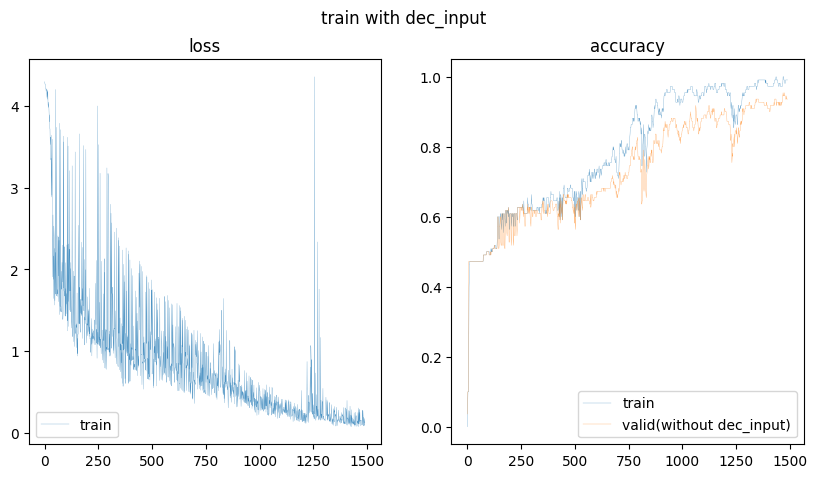

In [35]:
############################
# 학습 결과 시각화
############################
show_loss_score(train_losses, train_scores, valid_scores)

## 베스트 모델 테스트

In [3]:
############################
# 베스트 모델 로드
############################
model.load_state_dict(torch.load(early_stopping.best_model_path))

############################
# 테스트
############################
# 데이터셋 생성
test_dataset = GerEngDataset(
    vocab=vocab,
    X=X,
    y=y,
    max_len=max_len,
    emb_type=EMBEDDING_TYPE,
)
test_dataset.eval()
# 데이터 로더 생성
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# 모델 평가
test_preds, _ = test(model, test_loader, DEVICE, is_target=False)
# 결과 확인
for pred, data in zip(test_preds, test_dataset):
    feature, _, target = data
    # nparray로 변환
    feature = feature.numpy().argmax(axis=-1)
    target = target.numpy().argmax(axis=-1)[:-1]
    pred = pred.argmax(axis=-1)[:-1]
    # 인덱스 -> 단어로 변환
    feature = [vocab.idx2wrd(idx) if idx != vocab.wrd2idx('<pad>') else '' for idx in feature]
    target = [vocab.idx2wrd(idx) if idx != vocab.wrd2idx('<pad>') else '' for idx in target]
    pred = [vocab.idx2wrd(idx) if idx != vocab.wrd2idx('<pad>') else '' for idx in pred]
    # 출력
    print('feature : ', *feature)
    print('target  : ', *target)
    print('pred    : ', *pred)
    print('--------------------------------------------')

feature :  ich mochte ein bier     
target  :  i want a beer     
pred    :  i love a      
--------------------------------------------
feature :  guarda mi video      
target  :  watch my video      
pred    :  watch my video      
--------------------------------------------
feature :  hallo mein name ist kim    
target  :  hello my name is kim    
pred    :  hello my name is kim    
--------------------------------------------
feature :  schau dir den mond an    
target  :  look at the moon     
pred    :  look at the moon     
--------------------------------------------
feature :  du verstehst das nicht     
target  :  you do not understand     
pred    :  you do not understand     
--------------------------------------------
feature :  du verlinkst mich      
target  :  you link me      
pred    :  you link me      
--------------------------------------------
feature :  ich liebe dich      
target  :  i love you      
pred    :  i love you      
-------------------------------

In [4]:
############################
# 예측
############################
# 예측할 데이터
test_sentence = [
    'hallo mein name ist jullia',
]
# 데이터 전처리
test_sentence_split = [sentence.split() for sentence in test_sentence]
# 데이터셋 생성
test_dataset = GerEngDataset(
    vocab=vocab,
    X=test_sentence_split,
    y=None,
    max_len=max_len,
    emb_type=EMBEDDING_TYPE,
)
test_dataset.eval()
# 데이터 로더 생성
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# 모델 평가
test_preds, _ = test(model, test_loader, DEVICE, is_target=False)
# 결과 확인
for idx, (pred, data) in enumerate(zip(test_preds, test_dataset)):
    feature, _, _ = data
    # nparray로 변환
    feature = feature.numpy().argmax(axis=-1)
    pred = pred.argmax(axis=-1)[:-1]
    # 인덱스 -> 단어로 변환
    feature = [vocab.idx2wrd(idx) if idx != vocab.wrd2idx('<pad>') else '' for idx in feature]
    pred = [vocab.idx2wrd(idx) if idx != vocab.wrd2idx('<pad>') else '' for idx in pred]
    # 출력
    print('origin feature : ', test_sentence[idx])
    print('input feature  : ', *feature)
    print('pred    : ', *pred)
    print('--------------------------------------------')

origin feature :  hallo mein name ist jullia
input feature  :  hallo mein name ist <unk>    
pred    :  hello my name is kim    
--------------------------------------------
